In [24]:
import numpy as np
from scipy.optimize import curve_fit
from utils import sample_observed_data_berkson, sample_observed_data_classical, run_ols, tls

In [48]:
confidence_level = 0.90
num_realizations = 100
seed = 12
folder_path = '/dcs/pg23/u1604520/mem/results/linear_classical/new/misp/'
folder_path_simex = folder_path+'simex/linear_classical_unifstart_misp/'
# folder_path = '/dcs/pg23/u1604520/mem/results/linear_classical/new/'
# folder_path_simex = folder_path+'simex/'


In [49]:
scales_nu = [0.000001, 0.5,  1.0, 2.0] 
num_scales = len(scales_nu)
c = 1 #0.1 #0.00001 #100
n = 100
B = 200
theta_star = np.array([1,2]) 
loc_x = 10
scale_x = 2
scale_eps = 0.5
num_methods = 4

In [50]:
def reg_func(theta,x):
    return theta[0] + theta[1]*x

In [51]:
def linear_model(x, a, b):
    return a + b*x

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
mses = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
stds = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
for j, scale_nu in enumerate(scales_nu):
    seed = 12
    for r in range(num_realizations):
        seed += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        if scale_nu == 1.0:
            simex_sample = np.loadtxt(folder_path_simex+f'lin_simex_scale_nu{1}_seed{seed}.txt')
        elif scale_nu == 2.0:
            simex_sample = np.loadtxt(folder_path_simex+f'lin_simex_scale_nu{2}_seed{seed}.txt')
        else:
            simex_sample = np.loadtxt(folder_path_simex+f'lin_simex_scale_nu{scale_nu}_seed{seed}.txt')
        data, x = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        lr = LinearRegression(fit_intercept=True)
        lr.fit(data[:,0].reshape(-1, 1), data[:,1].reshape(-1, 1))
        ww = lr.coef_
        bb = lr.intercept_
        ls_estimator = np.array([bb[0], ww[0][0]])
        tls_estimator = tls(data[:,0], data[:,1]).squeeze()
        #print(ls_estimator)
        mses[j, r, 0, :] = np.asarray((mean_boot_sample - theta_star)**2)
        mses[j, r, 1, :] = np.asarray((simex_sample - theta_star)**2)
        mses[j, r, 2, :] = np.asarray((ls_estimator - theta_star)**2)
        mses[j, r, 3, :] = np.asarray((tls_estimator - theta_star)**2)


    mses_over_runs = np.mean(mses, axis=1)
    stds_mses_over_runs = np.std(mses, axis=1)
        
    print(f"Mean Squared error for Robust-MEM: {mses_over_runs[j, 0, :]}")
    print(f"Mean Squared error for SIMEX: {mses_over_runs[j, 1, :]}")
    print(f"Mean Squared error for Least Squares: {mses_over_runs[j, 2, :]}")
    print(f"Mean Squared error for Total Least Squares: {mses_over_runs[j, 3, :]}")
    print(f"Std - Mean Squared error for Robust-MEM: {stds_mses_over_runs[j, 0, :]}")
    print(f"Std - Mean Squared error for SIMEX: {stds_mses_over_runs[j, 1, :]}")
    print(f"Std - Mean Squared error for Least Squares: {stds_mses_over_runs[j, 2, :]}")
    print(f"Std - Mean Squared error for Total Least Squares: {stds_mses_over_runs[j, 3, :]}")

Mean Squared error for Robust-MEM: [1.61778382 0.01296523]
Mean Squared error for SIMEX: [0.07000895 0.00071951]
Mean Squared error for Least Squares: [0.0629187  0.00061999]
Mean Squared error for Total Least Squares: [0.11790355 0.00116791]
Std - Mean Squared error for Robust-MEM: [0.12836972 0.00151708]
Std - Mean Squared error for SIMEX: [0.07290531 0.00077921]
Std - Mean Squared error for Least Squares: [0.08277571 0.00082179]
Std - Mean Squared error for Total Least Squares: [0.15553878 0.0015558 ]
Mean Squared error for Robust-MEM: [1.58537079 0.01263052]
Mean Squared error for SIMEX: [1.12683293 0.01133072]
Mean Squared error for Least Squares: [1.63152243 0.016457  ]
Mean Squared error for Total Least Squares: [0.31299728 0.00304987]
Std - Mean Squared error for Robust-MEM: [0.16094694 0.00268069]
Std - Mean Squared error for SIMEX: [0.68094152 0.00677145]
Std - Mean Squared error for Least Squares: [1.23182079 0.01223997]
Std - Mean Squared error for Total Least Squares: [0.5

### Make a table

In [54]:
import pandas as pd

MSE and STD

In [55]:
def create_dataframe(mse_array, std_array, scale_nu, method_name):
    
    data = {'Param': ['$\theta_1$', '$\theta_2$'], 'MSE': mse_array, 'Std': std_array, '$\sigma_\nu$': scale_nu, 'Method': [method_name]*len(mse_array)}
    df = pd.DataFrame(data)
    
    return df

In [56]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,0,:], stds_mses_over_runs[i,0,:], scale_nu, 'Robust-MEM (TLS)')
    dfs.append(df)
robustmem_df = pd.concat(dfs, ignore_index=True)

In [57]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,1,:], stds_mses_over_runs[i,1,:], scale_nu, 'SIMEX')
    dfs.append(df)
simex_df = pd.concat(dfs, ignore_index=True)

In [58]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,2,:], stds_mses_over_runs[i,2,:], scale_nu, 'LS')
    dfs.append(df)
ls_df = pd.concat(dfs, ignore_index=True)

In [59]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,3,:], stds_mses_over_runs[i,3,:], scale_nu, 'TLS')
    dfs.append(df)
tls_df = pd.concat(dfs, ignore_index=True)

In [60]:
df_all = pd.concat([robustmem_df, simex_df, ls_df, tls_df])

In [61]:
df_all

,Param,MSE,Std,$\sigma_\nu$,Method
0,$\theta_1$,1.617784,0.128370,0.000001,Robust-MEM (TLS)
1,$\theta_2$,0.012965,0.001517,0.000001,Robust-MEM (TLS)
2,$\theta_1$,1.585371,0.160947,0.500000,Robust-MEM (TLS)
3,$\theta_2$,0.012631,0.002681,0.500000,Robust-MEM (TLS)
4,$\theta_1$,1.464215,0.222341,1.000000,Robust-MEM (TLS)
5,$\theta_2$,0.012101,0.004466,1.000000,Robust-MEM (TLS)
6,$\theta_1$,1.011495,0.334759,2.000000,Robust-MEM (TLS)
7,$\theta_2$,0.010625,0.007576,2.000000,Robust-MEM (TLS)
0,$\theta_1$,0.070009,0.072905,0.000001,SIMEX
1,$\theta_2$,0.000720,0.000779,0.000001,SIMEX


In [62]:
gb = df_all.groupby(['Method', 'Param', '$\sigma_\nu$']).mean()

In [63]:
pivot_df = gb.pivot_table(index=['Method', 'Param'], columns='$\sigma_\nu$', values=['MSE','Std'])

# Flatten the MultiIndex columns
pivot_df.columns = [f'{col[0]}-{col[1]}' for col in pivot_df.columns]

cols = pivot_df.columns.tolist()
mse_cols = [col for col in cols if 'MSE' in col]
std_cols = [col for col in cols if 'Std' in col]
rearranged_cols = [item for pair in zip(mse_cols, std_cols) for item in pair]
pivot_df = pivot_df[rearranged_cols]

# Reset index to make 'method' and 'param' regular columns
pivot_df.reset_index(inplace=True)
pivot_df

,Method,Param,MSE-1e-06,Std-1e-06,MSE-0.5,Std-0.5,MSE-1.0,Std-1.0,MSE-2.0,Std-2.0
0,LS,$\theta_1$,0.062919,0.082776,1.631522,1.231821,16.944642,7.153086,103.849703,21.629226
1,LS,$\theta_2$,0.000620,0.000822,0.016457,0.012240,0.169758,0.070724,1.035480,0.208795
2,Robust-MEM (TLS),$\theta_1$,1.617784,0.128370,1.585371,0.160947,1.464215,0.222341,1.011495,0.334759
3,Robust-MEM (TLS),$\theta_2$,0.012965,0.001517,0.012631,0.002681,0.012101,0.004466,0.010625,0.007576
4,SIMEX,$\theta_1$,0.070009,0.072905,1.126833,0.680942,15.404102,4.711574,99.524158,16.695127
5,SIMEX,$\theta_2$,0.000720,0.000779,0.011331,0.006771,0.154158,0.046475,0.992808,0.159060
6,TLS,$\theta_1$,0.117904,0.155539,0.312997,0.561202,1.470010,1.947535,14.870571,11.411518
7,TLS,$\theta_2$,0.001168,0.001556,0.003050,0.005588,0.014638,0.018641,0.149657,0.112099


In [64]:
pivot_df = pivot_df.groupby(['Method', 'Param']).mean()
pivot_df

MSE-1e-06  Std-1e-06   MSE-0.5   Std-0.5  \
Method           Param                                                  
LS               $\theta_1$   0.062919   0.082776  1.631522  1.231821   
                 $\theta_2$   0.000620   0.000822  0.016457  0.012240   
Robust-MEM (TLS) $\theta_1$   1.617784   0.128370  1.585371  0.160947   
                 $\theta_2$   0.012965   0.001517  0.012631  0.002681   
SIMEX            $\theta_1$   0.070009   0.072905  1.126833  0.680942   
                 $\theta_2$   0.000720   0.000779  0.011331  0.006771   
TLS              $\theta_1$   0.117904   0.155539  0.312997  0.561202   
                 $\theta_2$   0.001168   0.001556  0.003050  0.005588   

                               MSE-1.0   Std-1.0     MSE-2.0    Std-2.0  
Method           Param                                                   
LS               $\theta_1$  16.944642  7.153086  103.849703  21.629226  
                 $\theta_2$   0.169758  0.070724    1.035480   0.208795  
Robust-MEM (TLS) $\theta_1$   1.464215  0.222341    1.011495   0.334759  
                 $\theta_2$   0.012101  0.004466    0.010625   0.007576  
SIMEX            $\theta_1$  15.404102  4.711574   99.524158  16.695127  
                 $\theta_2$   0.154158  0.046475    0.992808   0.159060  
TLS              $\theta_1$   1.470010  1.947535   14.870571  11.411518  
                 $\theta_2$   0.014638  0.018641    0.149657   0.112099

In [65]:
new_df = pivot_df.copy(deep=True)
nus = [1e-06, 0.5, 1.0, 2.0]
# Iterate over columns
for i, nu in enumerate(nus):  # Assuming you have two pairs a_i and b_i
    # Extract corresponding pairs
    a_col = f'MSE-{nu}'
    b_col = f'Std-{nu}'
    # Concatenate values for the title
    new_df[f'$\sigma_\nu = {nu}$'] = pivot_df[a_col].round(3).astype(str) + ' ' + '(' + pivot_df[b_col].round(3).astype(str) + ')'
    new_df = new_df.drop(a_col, axis=1)
    new_df = new_df.drop(b_col, axis=1) 
    

new_df

$\sigma_\nu = 1e-06$ $\sigma_\nu = 0.5$  \
Method           Param                                                
LS               $\theta_1$        0.063 (0.083)      1.632 (1.232)   
                 $\theta_2$        0.001 (0.001)      0.016 (0.012)   
Robust-MEM (TLS) $\theta_1$        1.618 (0.128)      1.585 (0.161)   
                 $\theta_2$        0.013 (0.002)      0.013 (0.003)   
SIMEX            $\theta_1$         0.07 (0.073)      1.127 (0.681)   
                 $\theta_2$        0.001 (0.001)      0.011 (0.007)   
TLS              $\theta_1$        0.118 (0.156)      0.313 (0.561)   
                 $\theta_2$        0.001 (0.002)      0.003 (0.006)   

                            $\sigma_\nu = 1.0$ $\sigma_\nu = 2.0$  
Method           Param                                             
LS               $\theta_1$     16.945 (7.153)    103.85 (21.629)  
                 $\theta_2$       0.17 (0.071)      1.035 (0.209)  
Robust-MEM (TLS) $\theta_1$      1.464 (0.222)      1.011 (0.335)  
                 $\theta_2$      0.012 (0.004)      0.011 (0.008)  
SIMEX            $\theta_1$     15.404 (4.712)    99.524 (16.695)  
                 $\theta_2$      0.154 (0.046)      0.993 (0.159)  
TLS              $\theta_1$       1.47 (1.948)    14.871 (11.412)  
                 $\theta_2$      0.015 (0.019)       0.15 (0.112)

In [66]:
latex_table =new_df.to_latex()
print(latex_table)

\begin{tabular}{llllll}
\toprule
 &  & $\sigma_
u = 1e-06$ & $\sigma_
u = 0.5$ & $\sigma_
u = 1.0$ & $\sigma_
u = 2.0$ \\
Method & Param &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{LS} & $	heta_1$ & 0.063 (0.083) & 1.632 (1.232) & 16.945 (7.153) & 103.85 (21.629) \\
 & $	heta_2$ & 0.001 (0.001) & 0.016 (0.012) & 0.17 (0.071) & 1.035 (0.209) \\
\cline{1-6}
\multirow[t]{2}{*}{Robust-MEM (TLS)} & $	heta_1$ & 1.618 (0.128) & 1.585 (0.161) & 1.464 (0.222) & 1.011 (0.335) \\
 & $	heta_2$ & 0.013 (0.002) & 0.013 (0.003) & 0.012 (0.004) & 0.011 (0.008) \\
\cline{1-6}
\multirow[t]{2}{*}{SIMEX} & $	heta_1$ & 0.07 (0.073) & 1.127 (0.681) & 15.404 (4.712) & 99.524 (16.695) \\
 & $	heta_2$ & 0.001 (0.001) & 0.011 (0.007) & 0.154 (0.046) & 0.993 (0.159) \\
\cline{1-6}
\multirow[t]{2}{*}{TLS} & $	heta_1$ & 0.118 (0.156) & 0.313 (0.561) & 1.47 (1.948) & 14.871 (11.412) \\
 & $	heta_2$ & 0.001 (0.002) & 0.003 (0.006) & 0.015 (0.019) & 0.15 (0.112) \\
\cline{1-6}
\bottomrule
\end{tabular}



Plot

In [67]:
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [68]:
pip install seaborn

/dcs/pg23/u1604520/.conda/envs/mem-env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


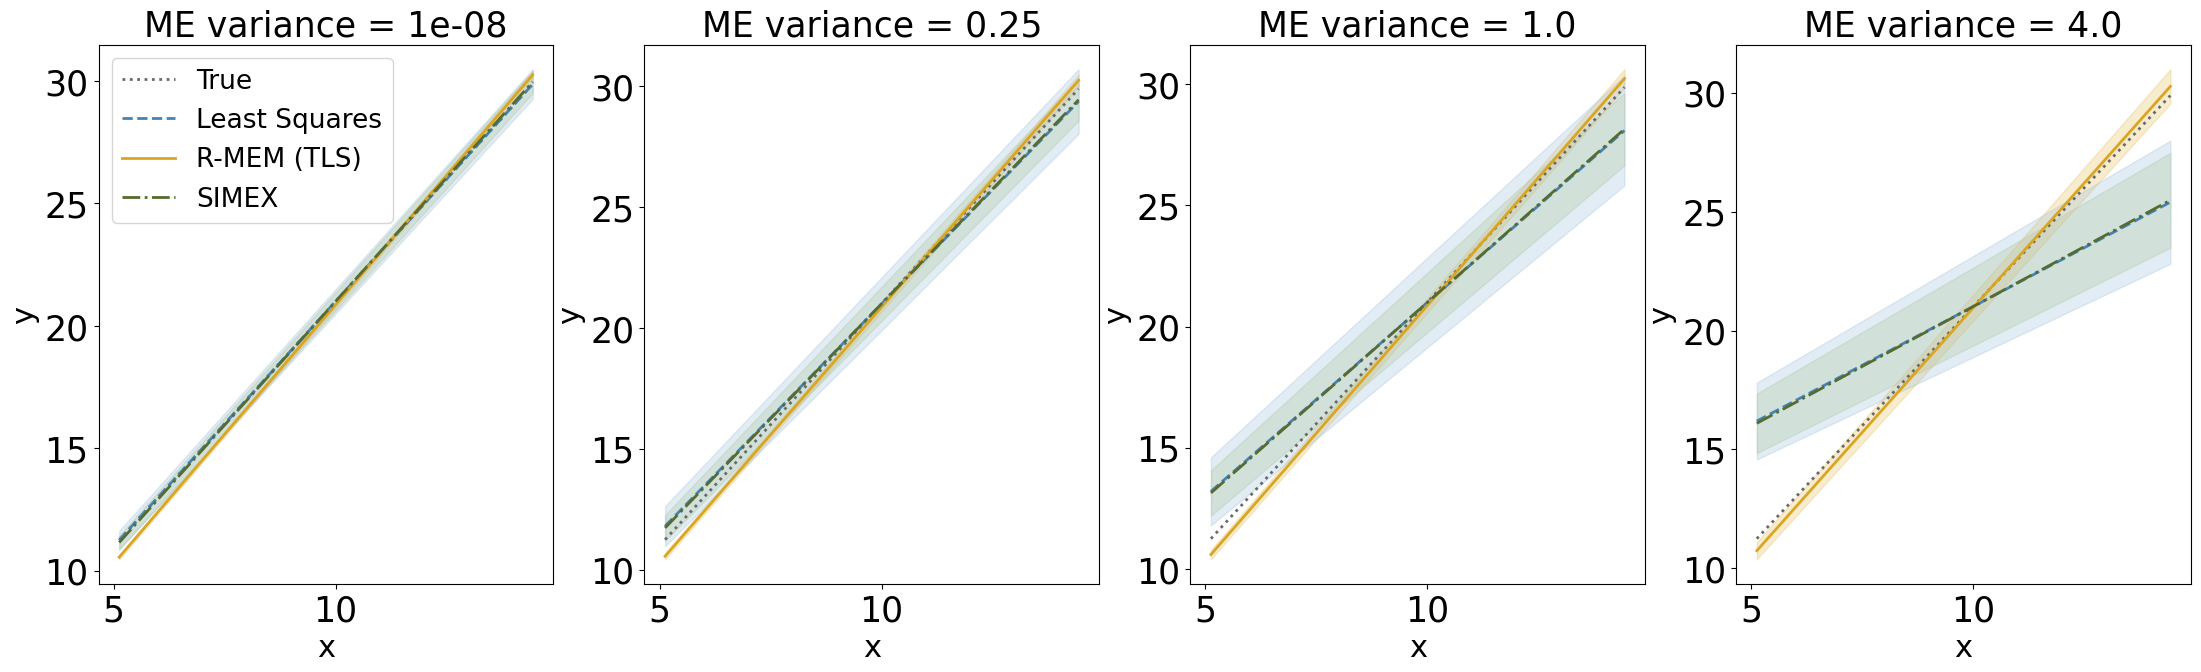

In [69]:
import matplotlib.pyplot as plt
num_methods = 3
num_scales = len(scales_nu)
fig, ax_array = plt.subplots(1, num_scales, figsize=(27,7))
credible_interval = 0.90
n = 100
regs = np.zeros((num_realizations, num_methods, n))
lower_bounds = np.zeros((num_methods, n))
upper_bounds = np.zeros((num_methods, n))
means = np.zeros((num_methods, n))
for ax, j in zip(ax_array.flatten(), range(0, num_scales)):
    scale_nu = scales_nu[j]
    seed = 12
    thetas_over_run = np.zeros((len(theta_star), num_methods, num_realizations))
    for r in range(num_realizations):
        seed += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        #print(boot_sample)
        if scale_nu == 1.0:
            simex_sample = np.loadtxt(folder_path_simex+f'lin_simex_scale_nu{1}_seed{seed}.txt')
        elif scale_nu == 2.0:
            simex_sample = np.loadtxt(folder_path_simex+f'lin_simex_scale_nu{2}_seed{seed}.txt')
        else:
            simex_sample = np.loadtxt(folder_path_simex+f'lin_simex_scale_nu{scale_nu}_seed{seed}.txt')
        data, xis_star = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        initial_guess = [0,0] #[0, 4]  # Initial parameter guess
        ls_estimator, _ = curve_fit(linear_model, data[:,0], data[:,1], p0=initial_guess)
        thetas_over_run[:, 0, r] = mean_boot_sample
        thetas_over_run[:, 1, r] = simex_sample
        thetas_over_run[:, 2, r] = ls_estimator
        xis_star_sorted = np.sort(xis_star)
        regs[r,0,:] = reg_func(thetas_over_run[:,0,r], xis_star_sorted)
        regs[r,1,:] = reg_func(thetas_over_run[:,1,r], xis_star_sorted)
        regs[r,2,:] = reg_func(thetas_over_run[:,2,r], xis_star_sorted)
        
    # lower_bounds[0, :] = np.percentile(regs[:,0,:], (1 - credible_interval) / 2 * 100, axis=0)
    # upper_bounds[0, :] = np.percentile(regs[:,0,:], (1 + credible_interval) / 2 * 100, axis=0)
    #means[0, :] = np.mean(regs[:,0,:], axis=0)
    means[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1), xis_star_sorted)
    lower_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) - thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)
    upper_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) + thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)
    # lower_bounds[1, :] = np.percentile(regs[:,1,:], (1 - credible_interval) / 2 * 100, axis=0)
    # upper_bounds[1, :] = np.percentile(regs[:,1,:], (1 + credible_interval) / 2 * 100, axis=0)
    #means[1, :] = np.mean(regs[:,1,:], axis=0)
    means[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1), xis_star_sorted)
    lower_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) - thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)
    upper_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) + thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)
    # lower_bounds[2, :] = np.percentile(regs[:,2,:], (1 - credible_interval) / 2 * 100, axis=0)
    # upper_bounds[2, :] = np.percentile(regs[:,2,:], (1 + credible_interval) / 2 * 100, axis=0)
    #means[2, :] = np.mean(regs[:,2,:], axis=0)
    means[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1), xis_star_sorted)
    lower_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) - thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    upper_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) + thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    
    
    Y_real = reg_func(theta_star, xis_star_sorted)
    
    ax.plot(xis_star_sorted, Y_real, linestyle='dotted', label='True', color='dimgrey', lw=2)
    
    ax.plot(xis_star_sorted, means[2,:], linestyle='dashed', label='Least Squares', color='#4682B4', lw=2)
    
    ax.plot(xis_star_sorted, means[0, :], linestyle='solid', label='R-MEM (TLS)', color='goldenrod',lw=2)
   
    ax.plot(xis_star_sorted, means[1, :], linestyle='dashdot', label='SIMEX',color='#556B2F', lw=2)
    ax.fill_between(xis_star_sorted, lower_bounds[1, :], upper_bounds[1, :], color=lighten_color('#556B2F'), alpha=0.3)

    ax.fill_between(xis_star_sorted, lower_bounds[0, :], upper_bounds[0, :], color=lighten_color('goldenrod', 0.7), alpha=0.3)
    ax.fill_between(xis_star_sorted, lower_bounds[2, :], upper_bounds[2, :], color=lighten_color('#4682B4'), alpha=0.3)
    
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    ax.patch.set_facecolor('white')
    if j == 0:
        ax.set_title(f'ME variance = 1e-08', fontsize=25)
    elif j == 1 or j == 3:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)
    elif j == 2:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)

    ax.set_xlabel('x',fontsize=22)
    ax.set_ylabel('y',fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
    if j == 0:
        ax.legend(fontsize=19)